# Importing libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis
import yfinance as yf

from Stock_Data import get_close

In [3]:
%run "Git.ipynb".ipynb
Binance=BinanceAPI(binance_api_key,binance_api_secret)
git=GitHub(token,repo_owner,repo_name,branch)

# Importing Data

In [5]:
#start_date=datetime.datetime(2020,1,1)
start_date=datetime.datetime(2020,1,1)
today=datetime.datetime.today()

In [6]:
days=(today-start_date).days
days

1958

In [7]:
remaining=days%500
numbers_of_table=days//500

In [8]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:30].to_list()

In [9]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(data)
    
temp_end=(today-datetime.timedelta(days))
data=Binance.get_price(tickers,temp_end)
prices=prices.combine_first(data)
prices=prices.sort_index()
prices = prices[~prices.index.duplicated(keep='first')]
prices.index=pd.to_datetime(prices.index)

In [10]:
market_data_us=get_close(['SPY','GOLD.PA','BTC-USD'],start=start_date.strftime("%Y-%m-%d"),end=today.strftime("%Y-%m-%d"))
market_data_us.index=pd.to_datetime(market_data_us.index)
market_data_us = market_data_us[~market_data_us.index.duplicated(keep='first')]
market_data_us=market_data_us.sort_index().dropna()
market_data_us_returns=market_data_us.pct_change().sort_index()

In [11]:
# prices=prices.loc[market_data_us.index]
# prices['GOLD.PA']=market_data_us['GOLD.PA']

In [12]:
correlation_btc=market_data_us_returns['GOLD.PA'].rolling(30).corr(market_data_us_returns['BTC-USD']).dropna()
correlation_spy=market_data_us_returns['GOLD.PA'].rolling(30).corr(market_data_us_returns['SPY']).dropna()

#beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['BTC-USD']).dropna()/pct_change['BTC-USD'].rolling(30).var().dropna())

In [13]:
info=pd.DataFrame()
info['Correlation SPY']=correlation_spy
info['Correlation BTC']=correlation_btc

In [14]:
# info.iloc[-30:]

<Axes: >

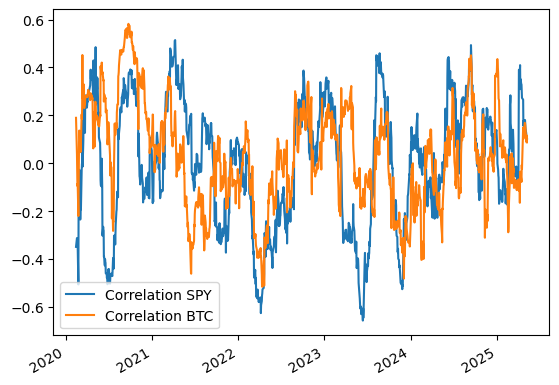

In [15]:
info.plot()

In [16]:
returns=np.log(1+prices.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na].sort_index()


C:\Users\Admin\AppData\Local\Temp\ipykernel_13420\3925264644.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns=np.log(1+prices.pct_change())


In [17]:
dataframe=prices[with_no_na].sort_index()
dataframe.index=pd.to_datetime(dataframe.index)

In [18]:
returns_to_use.index=pd.to_datetime(returns_to_use.index)
returns_to_use = returns_to_use[~returns_to_use.index.duplicated(keep='first')]

# Strategy Backtesting

In [20]:
month=list(sorted(set(returns_to_use.index + pd.offsets.BMonthEnd(0))))
#month_end=pd.to_datetime(mrat_wo_na.index)
month = pd.to_datetime(month)

idx1 = pd.Index(returns_to_use.iloc[:-1].index)
idx2 = pd.Index(month)
closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]

dates_end=list(closest_dates)
dates_end.insert(0,returns_to_use.index[1])
dates_end.append(returns_to_use.index[-1])
dates_end=sorted(list(set(dates_end)))
dates_end.pop(0)
dates_end=sorted(list(set(dates_end)))

In [21]:
results={}
btc_limit=np.where(returns_to_use.columns=='BTCUSDT')[0][0]
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]
# gold_positions=np.where(returns_to_use.columns=='GOLD.PA')[0][0]
#om_limit=np.where(returns_to_use.columns=='OMUSDT')[0][0]

In [22]:
for i in range(len(dates_end)-1):
    
    try:
        dataset=returns_to_use.loc[dates_end[i]:dates_end[i+1]]        
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        
        optimal=risk.optimize(objective='minimum_variance',constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00}#,
                                                                       ])# {'type': 'eq', 'fun': lambda weights: weights[gold_positions]-0.00}])
        
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
        pass

In [23]:
rolling_optimization=pd.DataFrame(results,index=dataframe.columns).T
rolling_optimization.loc[dates_end[0]]=1/len(dataframe.columns)
rolling_optimization=rolling_optimization.sort_index()

correlation_threshold=0.5
gold_limit=0.0
rolling_optimization_adjusted=rolling_optimization.copy()

correlation=pd.DataFrame(index=dates_end)
correlation['Correlation']=correlation_spy
correlation=correlation.ffill().bfill()

In [24]:
# for date in dates_end:
    
#     if abs(correlation.loc[date].item())<correlation_threshold:
        
#         temp=rolling_optimization_adjusted.loc[date]
#         sum_numerator=temp.loc[temp.index!='GOLD.PA'].sum()-gold_limit
    
#         normalized_weights=temp.loc[temp.index!='GOLD.PA']*sum_numerator
#         normalized_weights['GOLD.PA']=gold_limit
#         rolling_optimization_adjusted.loc[date]=normalized_weights
#     else:
        
#         continue

In [25]:
tracking={}
portfolio={}
investment_amount=1
initial_amount=investment_amount
perf=dataframe.pct_change()
transaction_fee=0.005
gold_limit=0.05
weight_dict={col: 1/returns_to_use.shape[1] for col in returns_to_use.columns}


for i in range(len(dates_end)-1):
    
    print(dates_end[i],investment_amount,investment_amount/initial_amount)

    
    temp=dataframe.loc[dates_end[i]:dates_end[i+1]].copy()
    initial_price=temp.iloc[0].to_dict()

    if dates_end[i]>dates_end[0]:

        top50=rolling_optimization_adjusted.loc[dates_end[i]]
        top50_dict=rolling_optimization_adjusted.loc[dates_end[i]].to_dict()
        weight_dict={}

        for key in temp.columns:

            if key in top50_dict: 
                weight_dict[key]=top50_dict[key]
            else:
                weight_dict[key]=0

                
    weight_vec=np.array(list(weight_dict.values()))
    
    inital_investment_per_stock={}
    shares={}

    for col in temp.columns:
        
        weighted_perf=weight_vec*perf.loc[dates_end[i]]
        
        inital_investment_per_stock[col]=weight_dict[col]*investment_amount*(1+weighted_perf.sum())
        shares[col]=inital_investment_per_stock[col]*(1-transaction_fee)/initial_price[col]

    tracking[dates_end[i]]=(weight_dict,shares,investment_amount,initial_price)

    temp=temp*shares    
    portfolio[dates_end[i]]=temp
    investment_amount=temp.iloc[-1].sum()
    

temp=dataframe.loc[dates_end[-2]:]*shares
portfolio[dates_end[-1]]=temp

2020-01-01 00:00:00 1 1.0
2020-01-31 00:00:00 1.4723626181493272 1.4723626181493272
2020-02-28 00:00:00 2.0008122581098813 2.0008122581098813
2020-03-31 00:00:00 1.4464074296337182 1.4464074296337182
2020-04-30 00:00:00 1.9499436041194753 1.9499436041194753
2020-05-29 00:00:00 1.9919836148171868 1.9919836148171868
2020-06-30 00:00:00 1.862205576678416 1.862205576678416
2020-07-31 00:00:00 2.5886085822746265 2.5886085822746265
2020-08-31 00:00:00 2.8082948861778383 2.8082948861778383
2020-09-30 00:00:00 2.623151539340893 2.623151539340893
2020-10-30 00:00:00 2.964972553748805 2.964972553748805
2020-11-30 00:00:00 3.9780108763179083 3.9780108763179083
2020-12-31 00:00:00 5.1295178801264765 5.1295178801264765
2021-01-29 00:00:00 8.179337725841759 8.179337725841759
2021-02-26 00:00:00 33.89742598187241 33.89742598187241
2021-03-31 00:00:00 44.91623789870459 44.91623789870459
2021-04-30 00:00:00 99.70029632524569 99.70029632524569
2021-05-31 00:00:00 77.87956650585754 77.87956650585754
2021

C:\Users\Admin\AppData\Local\Temp\ipykernel_13420\52590279.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  perf=dataframe.pct_change()


In [26]:
historical_portfolio=pd.DataFrame()
performance=pd.DataFrame()
for key in portfolio.keys():
    historical_portfolio=historical_portfolio.combine_first(portfolio[key])

<Axes: >

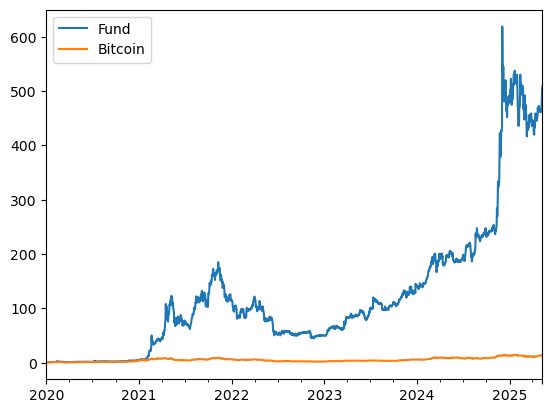

In [27]:
performance['Fund']=historical_portfolio.sum(axis=1)
performance['Bitcoin']=dataframe['BTCUSDT']
#performance['Mantra']=dataframe['OMUSDT']

performance_pct=performance.copy()
performance_pct=performance_pct.pct_change()

(1+performance_pct.iloc[:-2]).cumprod().plot()

In [28]:
years=sorted(list(set(performance.index.year)))

month_year=performance.index.strftime('%Y-%m')
month_year=sorted(list(set(month_year)))

<Axes: >

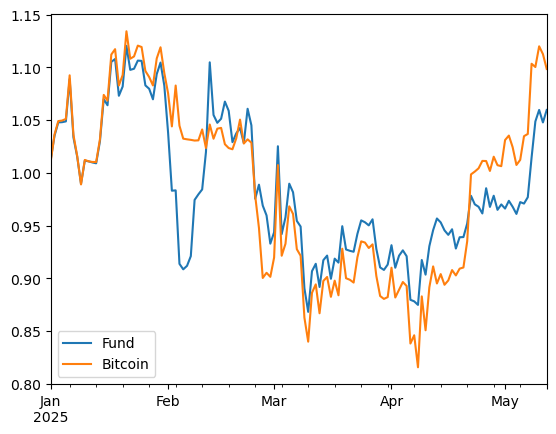

In [29]:
(1+performance_pct.loc['2025':]).cumprod().plot()

In [30]:
year_returns={}
for year in years:

    perf_year=performance.loc[str(year)].iloc[-1]/performance.loc[str(year)].iloc[0]-1
    year_returns[year]=perf_year

year_returns[years[-1]]=performance.loc[str(years[-1])].iloc[-2]/performance.loc[str(years[-1])].iloc[0]-1

In [31]:
year_returns_dataframe=pd.DataFrame(year_returns)
year_returns_dataframe

,2020,2021,2022,2023,2024,2025
Fund,4.124217,21.022999,-0.562101,1.803078,2.386865,0.034823
Bitcoin,3.016697,0.575665,-0.653364,1.544636,1.118084,0.100709


In [32]:
month_returns={}
for month in month_year:

    perf_year=performance.loc[str(month)].iloc[-1]/performance.loc[str(month)].iloc[0]-1
    month_returns[month]=perf_year

#month_returns[month]=performance.loc[str(month_year[-1])].iloc[-2]/performance.loc[str(month_year[-1])].iloc[0]-1

In [33]:
month_returns_dataframe=pd.DataFrame(month_returns)
month_returns_dataframe

,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,...,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05
Fund,0.470841,0.283600,-0.248649,0.305888,0.010055,-0.106718,0.389475,0.014183,-0.079308,0.144153,...,0.156269,0.051515,0.079571,0.727260,0.118214,0.069271,-0.101390,-0.032487,0.041502,0.096797
Bitcoin,0.298859,-0.091746,-0.248649,0.297622,0.070388,-0.104131,0.227844,-0.012851,-0.096073,0.298694,...,-0.097623,0.105158,0.156009,0.387245,-0.037137,0.082859,-0.161828,-0.040836,0.105846,0.065373


In [34]:
metrics={}
metrics['Tracking Error']=(performance_pct['Fund']-performance_pct['Bitcoin']).std()*np.sqrt(252)
metrics['Fund Vol']=performance_pct['Fund'].std()*np.sqrt(252)
metrics['Bench Vol']=performance_pct['Bitcoin'].std()*np.sqrt(252)
metrics['Fund Return']=performance['Fund'].iloc[-2]/performance['Fund'].iloc[0]
metrics['Bench Return']=performance['Bitcoin'].iloc[-2]/performance['Bitcoin'].iloc[0]
metrics['Sharpe Ratio']=(1+metrics['Fund Return'])**(1/len(set(returns_to_use.index.year)))/metrics['Fund Vol']

In [35]:
indicators=pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['Indicators'])
indicators

,Indicators
Tracking Error,0.573779
Fund Vol,0.739055
Bench Vol,0.533519
Fund Return,502.637155
Bench Return,14.459126
Sharpe Ratio,3.291090


In [36]:
last_weights=tracking[dates_end[-2]][0]
weights=pd.DataFrame(last_weights.values(),index=last_weights.keys(),columns=['Weights Model'])

current_positions=Binance.get_inventory().round(4)
current_positions.columns=['Current Portfolio in USDT','Current Weights']
amount=current_positions.loc['Total']['Current Portfolio in USDT']

last_prices=Binance.get_price(list(last_weights.keys()))

quantities={}

for key in last_weights:
    quantities[key]=amount*last_weights[key]#/last_prices[key].values[0]

positions=pd.DataFrame(quantities.values(),index=quantities.keys(),columns=['Mark To Market Model'])
positions=pd.concat([positions,weights],axis=1)

condition=current_positions.index!='Total'
portfolio=pd.concat([positions,current_positions.loc[condition]],axis=1).fillna(0)
portfolio.loc['Total']=portfolio.sum(axis=0)
portfolio.sort_values(by='Weights Model',ascending=False).round(4)

,Mark To Market Model,Weights Model,Current Portfolio in USDT,Current Weights
Total,2008.9702,1.0000,2008.9701,1.0000
TRXUSDT,1771.4838,0.8818,131.8800,0.0656
BTCUSDT,104.8281,0.0522,909.8600,0.4529
BNBUSDT,91.3579,0.0455,1.1288,0.0006
LTCUSDT,41.3004,0.0206,0.0000,0.0000
XLMUSDT,0.0000,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0000,0.0000
BBUSDT,0.0000,0.0000,19.9880,0.0099
OMUSDT,0.0000,0.0000,197.0822,0.0981
JASMYUSDT,0.0000,0.0000,264.6851,0.1318


In [37]:
git.create_or_replace_notebook("Active Crypto Strategy.ipynb")

File 'Active Crypto Strategy.ipynb' exists. Replacing the file...
✅ File 'Active Crypto Strategy.ipynb' successfully pushed/updated to GitHub!


In [38]:
last_weights=tracking[dates_end[-2]][0]
weights=pd.DataFrame(last_weights.values(),index=last_weights.keys(),columns=['Weights Model'])
weights

,Weights Model
ADAUSDT,0.000000
BCHUSDT,0.000000
BNBUSDT,0.045475
BTCUSDT,0.052180
DOGEUSDT,0.000000
ETCUSDT,0.000000
ETHUSDT,0.000000
HBARUSDT,0.000000
LINKUSDT,0.000000
LTCUSDT,0.020558
